# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [8]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import UpperBoundWeakProperLoss
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [9]:
dataset_name = 'Cifar10'
Data = Data_handling(
    # dataset='mnist',
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

KeyboardInterrupt: 

In [ ]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


ValueError: Must pass 2-d input. shape=(50000, 3, 32, 32)

In [ ]:
Data.num_classes

10

In [ ]:
""" df_2_plot = df.iloc[0:1000]
features = ['feature_102', 'feature_103']
visualize_dataset(
    df_2_plot,
    features=features,
    classes=Data.num_classes,
    title=dataset_name,
) """


In [ ]:
""" df_2_plot[[features[0], features[1]]] """


Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [ ]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
#print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.34217728e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.34217728e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.35544320e-02 3.35544320e-02]
 ...
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  0.00000000e+00 2.04800000e-06]
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  2.04800000e-06 0.00000000e+00]
 [5.12000000e-07 5.12000000e-07 5.12000000e-07 ... 5.12000000e-07
  5.12000000e-07 5.12000000e-07]]
Generated z (noisy labels):
tensor([136, 274, 162,  ...,   8, 767, 320], dtype=torch.int32)
Inputs batch shape: torch.Size([64, 3, 32, 32])
Weak (partial) labels shape: torch.Size([64])
True one-hot labels shape: torch.Size([64, 10])


In [ ]:
#weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
#df['target'] = [i for i in weakener.w.numpy()]
#df

# 1) 展平成 (N, 3072)
X = Data.train_dataset.data                # (N, 3, 32, 32)  (torch tensor)
X2 = X.view(X.shape[0], -1).cpu().numpy()  # (N, 3072)

weak_df = pd.DataFrame(X2, columns=[f'feature_{i}' for i in range(X2.shape[1])])

# 2) 加 true label（如果 targets 是 one-hot，就转成 class index）
y = Data.train_dataset.targets
if hasattr(y, "ndim") and y.ndim == 2:
    y = y.argmax(dim=1)
weak_df["target"] = y.cpu().numpy()

# 3) 加 weak label（weakener.w 可能是一维或二维：做个兼容）
w = weakener.w
w_np = w.detach().cpu().numpy()

if w_np.ndim == 1:
    weak_df["weak"] = w_np
else:
    # 如果是 one-hot / multi-hot (N,C)，你可以：
    # A) 每一类一列（适合做统计）
    for c in range(w_np.shape[1]):
        weak_df[f"weak_{c}"] = w_np[:, c]
    # 或 B) 压缩成“候选集合”（适合阅读）
    # weak_df["weak_set"] = [np.flatnonzero(row).tolist() for row in w_np]

weak_df


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,weak_0,weak_1,weak_2,weak_3,weak_4,weak_5,weak_6,weak_7,weak_8,weak_9
0,-0.537255,-0.662745,-0.607843,-0.466667,-0.231373,-0.066667,0.090196,0.137255,0.168628,0.168628,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.207843,-0.011765,-0.176471,-0.200000,-0.019608,0.215686,0.349020,0.411765,0.113726,-0.129412,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,1.000000,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,0.984314,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,-0.780392,-0.709804,-0.701961,-0.670588,-0.654902,-0.686275,-0.686275,-0.811765,-0.749020,-0.662745,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.317647,0.388235,0.435294,0.419608,0.388235,0.419608,0.443137,0.482353,0.482353,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.137255,0.184314,0.223529,0.215686,0.200000,0.200000,0.231373,0.262745,0.262745,0.262745,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
49996,1.000000,0.992157,1.000000,0.992157,0.992157,0.992157,0.992157,0.984314,0.992157,0.992157,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
49997,-0.725490,-0.686275,-0.670588,-0.694118,-0.662745,-0.647059,-0.623529,-0.600000,-0.584314,-0.560784,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
49998,0.482353,0.458824,0.450980,0.443137,0.427451,0.419608,0.411765,0.411765,0.419608,0.411765,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# visualize_dataset(
#     df,
#     features=['feature_0', 'feature_1'],
#     classes=3,
#     title='Iris Samples with Pie Markers for Multi-Label Entries'
# )



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

Using device: cpu
   epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0      1    0.092617    0.16248    0.2574             0.030664   

   test_detached_loss optimizer loss_fn repetition  initial_lr  actual_lr  \
0            0.030788       SGD    None       None         0.1        0.1   

   corr_p  epoch_time  
0     0.2   1277.0138  


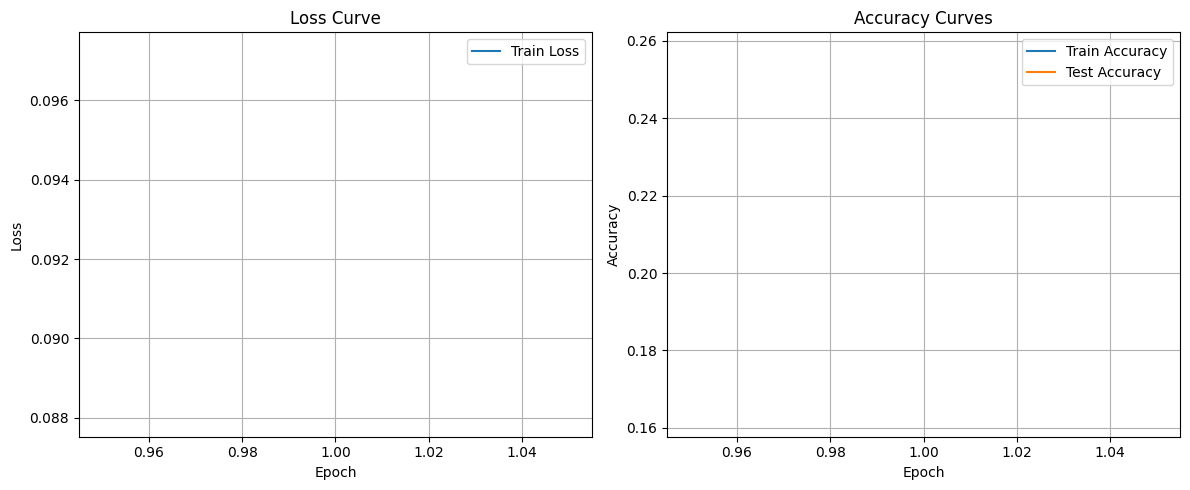

In [12]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")


import torch.nn as nn
import torchvision.models as models

def resnet18_cifar(num_classes: int):
    m = models.resnet18(weights=None)
    # CIFAR10: 32x32，改第一层卷积 + 去掉 maxpool
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18_cifar(Data.num_classes).to(device)


optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)




# 0) 先从 loader 拿一个 batch 推断 input_dim
""" xb, wb, yb = next(iter(train_loader))
input_dim = int(np.prod(xb.shape[1:]))   # CIFAR10 通常是 3*32*32=3072

print("xb shape:", xb.shape, "=> input_dim:", input_dim)

# 1) 模型：先 Flatten 再 MLP（这样即使 xb 是 4D 也能喂给 MLP）
model = nn.Sequential(
    nn.Flatten(start_dim=1),
    MLP(
        input_size=input_dim,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu'
    )
)
 """

""" model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
) """

""" optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
) """

#optimizer = optim.SGD(
#    model.parameters(),
#    lr=0.01,
#    momentum=0.0  # 0.9
#)

# 2. Training parameters
num_epochs = 1

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import os
print(os.getenv("PYTHONBREAKPOINT"))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)


# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = ForwardProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch import nn

# 1. 固定随机种子
torch.manual_seed(0)

B, C = 5, 4

logits = torch.randn(B, C, requires_grad=True)
z = torch.randint(0, C, (B,))

M = torch.rand(C, C)
M = M / M.sum(dim=1, keepdim=True)
F = M.clone()

# 这里贴上你的 MarginalChainProperLoss 和 ForwardProperLoss 定义
# loss_code="cross_entropy"

mc_loss_fn = MarginalChainProperLoss(M, loss_code="cross_entropy", reduction="mean")
fw_loss_fn = ForwardProperLoss(F, loss_code="cross_entropy", reduction="mean")

# Marginal chain
logits_mc = logits.clone().detach().requires_grad_(True)
loss_mc = mc_loss_fn(logits_mc, z)
loss_mc.backward()
grad_mc = logits_mc.grad.clone().detach()

# Forward
logits_fw = logits.clone().detach().requires_grad_(True)
loss_fw = fw_loss_fn(logits_fw, z)
loss_fw.backward()
grad_fw = logits_fw.grad.clone().detach()

print("loss_mc:", loss_mc.item())
print("loss_fw:", loss_fw.item())
print("loss diff:", abs(loss_mc.item() - loss_fw.item()))

print("grad same?", torch.allclose(grad_mc, grad_fw, atol=1e-6))
print("grad max diff:", (grad_mc - grad_fw).abs().max().item())


In [ ]:
# 取一个 batch
xb, zb, yb = next(iter(train_loader))   # 确保 zb 就是 z（weak index）
xb = xb.to(device)
zb = zb.to(device)

logits = model(xb)

fwd_loss_fn = ForwardProperLoss(weakener.M, "cross_entropy").to(device)
ub_loss_fn  = UpperBoundWeakProperLoss(weakener.M, "cross_entropy").to(device)

loss_fwd = fwd_loss_fn(logits, zb)
loss_ub  = ub_loss_fn(logits, zb)

print("loss_fwd:", loss_fwd.item())
print("loss_ub :", loss_ub.item())

g1 = torch.autograd.grad(loss_fwd, logits, retain_graph=True)[0]
g2 = torch.autograd.grad(loss_ub,  logits)[0]
print("grad norm fwd:", g1.norm().item())
print("grad norm ub :",  g2.norm().item())


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)


# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.015,
)
# 2. Training parameters
num_epochs = 90

em_loss = ForwardProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.015,
)
# 2. Training parameters
num_epochs = 400

em_loss = MarginalChainProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = ForwardProperLoss(weakener.M, loss_code="tsallis_0.5")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()